In [5]:
import pandas as pd
import time
import logging
import threading
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import psutil
import warnings
import os
from joblib import Parallel, delayed
import pickle
from datetime import datetime

warnings.filterwarnings('ignore')  
%matplotlib inline  

In [6]:
logger = logging.getLogger(__name__)

logger.propagate = False

# Hanya tambahkan handler jika belum ada
if not logger.handlers:
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(handler)

In [7]:
class SystemMonitor(threading.Thread):
    """Thread untuk memonitor penggunaan sumber daya sistem"""
    def __init__(self, interval=1):
        super().__init__()
        threading.Thread.__init__(self)
        self.interval = interval
        self.running = True
        self.cpu_usage = []
        self.memory_usage = []
        self.start_time = time.time()
        self.daemon	= True
        
    def run(self):
        while self.running:
            cpu = psutil.cpu_percent(interval=self.interval)
            memory = psutil.virtual_memory().percent
            self.cpu_usage.append(cpu)
            self.memory_usage.append(memory)
            
            logger.debug(f"Monitor: CPU {cpu}% | Memory {memory}%")
            
    def stop(self):
        self.running = False
        self.join()
        
    def get_stats(self):
        return {
            'avg_cpu': np.mean(self.cpu_usage),
            'max_cpu': np.max(self.cpu_usage),
            'avg_memory': np.mean(self.memory_usage),
            'max_memory': np.max(self.memory_usage),
            'duration': time.time() - self.start_time
        }
    def __getstate__(self):
        # Hentikan thread dan hapus atribut internal
        self.stop()
        state = self.__dict__.copy()
        for attr in ['_stderr', '_Thread__kwargs', '_Thread__args', '_tstate_lock']:
            if attr in state:
                del state[attr]
        return state


Program SystemMonitor merupakan sebuah kelas Python berbasis thread yang digunakan untuk memantau penggunaan sumber daya sistem seperti CPU dan memori secara berkala. Dengan memanfaatkan pustaka psutil, kelas ini akan berjalan di background dan mencatat persentase penggunaan CPU dan memori setiap interval waktu tertentu (default 1 detik). Data yang dikumpulkan akan disimpan dalam bentuk list dan bisa diambil dalam bentuk statistik seperti rata-rata, maksimum, dan durasi monitoring. Kelas ini juga dilengkapi fungsi untuk menghentikan thread dengan aman dan mendukung serialisasi (pickle) dengan cara menghapus atribut internal thread. Program ini berguna untuk memantau performa sistem saat menjalankan proses komputasi atau analisis data yang berat.

In [8]:
class ProgressTracker:
    def __init__(self, total_trees):
        self.total_trees = total_trees
        self.completed_trees = 0
        self.start_time = time.time()
        self.lock = threading.Lock()
        self.tree_times = []
        self.milestone_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        self.completed_milestones = set()
        
        # Statistik tambahan
        self.tree_depths = []
        self.tree_sizes = []
        
    def update_progress(self, tree_time, tree_depth=None, tree_size=None):
        with self.lock:
            self.completed_trees += 1
            self.tree_times.append(tree_time)
            
            if tree_depth is not None:
                self.tree_depths.append(tree_depth)
            if tree_size is not None:
                self.tree_sizes.append(tree_size)
            
            percent_complete = (self.completed_trees / self.total_trees) * 100
            
            # Tampilkan milestone hanya sekali
            for milestone in self.milestone_percentages:
                if (percent_complete >= milestone and 
                    milestone not in self.completed_milestones):
                    
                    self.completed_milestones.add(milestone)
                    elapsed_time = time.time() - self.start_time
                    avg_tree_time = np.mean(self.tree_times)
                    estimated_total_time = avg_tree_time * self.total_trees
                    remaining_time = max(0, estimated_total_time - elapsed_time)
                    
                    # Info tambahan
                    avg_depth = np.mean(self.tree_depths) if self.tree_depths else 0
                    avg_size = np.mean(self.tree_sizes) if self.tree_sizes else 0
                    
                    logger.info(
                        f"Progress: {milestone}% completed - "
                        f"Processed {self.completed_trees}/{self.total_trees} trees | "
                        f"Avg Depth: {avg_depth:.1f} | "
                        f"Avg Size: {avg_size:.1f} nodes | "
                        f"Elapsed Time: {elapsed_time:.1f}s | "
                        f"Estimated Remaining Time: {remaining_time:.1f}s"
                    )
                    break
    
    def final_report(self):
        total_time = time.time() - self.start_time
        stats = {
            'total_time': total_time,
            'avg_tree_time': np.mean(self.tree_times),
            'min_tree_time': np.min(self.tree_times),
            'max_tree_time': np.max(self.tree_times),
            'avg_tree_depth': np.mean(self.tree_depths) if self.tree_depths else 0,
            'avg_tree_size': np.mean(self.tree_sizes) if self.tree_sizes else 0,
            'trees_per_second': self.total_trees / total_time if total_time > 0 else 0
        }
        
        logger.info("\n=== Training Summary ===")
        logger.info(f"Total Training Time: {stats['total_time']:.2f} seconds")
        logger.info(f"Average Tree Time: {stats['avg_tree_time']:.4f} seconds")
        logger.info(f"Fastest Tree: {stats['min_tree_time']:.4f} seconds")
        logger.info(f"Slowest Tree: {stats['max_tree_time']:.4f} seconds")
        logger.info(f"Average Tree Depth: {stats['avg_tree_depth']:.1f}")
        logger.info(f"Average Tree Size: {stats['avg_tree_size']:.1f} nodes")
        logger.info(f"Training Speed: {stats['trees_per_second']:.2f} trees/second")
        
        return stats


Program ProgressTracker digunakan untuk memantau dan mencatat kemajuan proses pelatihan pohon keputusan (decision trees) secara real-time. Program ini menyimpan jumlah total pohon yang akan dilatih dan secara bertahap memperbarui jumlah pohon yang telah selesai. Setiap kali pelatihan satu pohon selesai, informasi seperti waktu pelatihan, kedalaman pohon, dan jumlah nodenya dicatat. Program juga menampilkan laporan pada titik-titik tertentu (milestone) seperti 10%, 20%, hingga 100% untuk memberikan gambaran progres secara bertahap. Selain itu, setelah seluruh proses selesai, final_report() akan memberikan ringkasan statistik pelatihan seperti waktu total, waktu rata-rata per pohon, kedalaman dan ukuran rata-rata pohon, serta kecepatan pelatihan. Program ini sangat berguna untuk melacak performa dan efisiensi dalam membangun banyak pohon, seperti saat membangun model Random Forest.

In [9]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, task='regression'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task  # 'regression' or 'classification'
        self.tree = None
        self.feature_indices = None

    def calculate_impurity(self, y):
        """Menghitung impurity berdasarkan task"""
        if len(y) == 0:
            return 0
            
        y = np.asarray(y).flatten()
        if self.task == 'regression':
            # Mean Squared Error untuk regresi
            return np.mean((y - np.mean(y)) ** 2)
        else:
            # Gini Impurity untuk klasifikasi
            classes = np.unique(y)
            gini = 1.0
            for c in classes:
                p = np.sum(y == c) / len(y)
                gini -= p ** 2
            return gini

    def find_best_split(self, X, y):
        """Mencari split terbaik untuk dataset"""
        X = np.asarray(X)
        y = np.asarray(y).flatten()  # Pastikan y adalah 1D array
        
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split or n_features == 0:
            return None, None
            
        current_impurity = self.calculate_impurity(y)
        best_gain = 0.0
        best_feature, best_threshold = None, None
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            if len(unique_values) <= 1:
                continue
            if len(unique_values) > 10:
                percentiles = np.linspace(10, 90, num=10)
                thresholds = np.percentile(feature_values, percentiles)
            else:
                # Gunakan titik tengah antara nilai unik yang berurutan
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            for threshold in thresholds:
                # Buat mask boolean
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                if n_left < self.min_samples_split or n_right < self.min_samples_split:
                       continue
                left_impurity = self.calculate_impurity(y[left_mask])
                right_impurity = self.calculate_impurity(y[right_mask])
                weighted_impurity = (n_left * left_impurity + n_right * right_impurity) / n_samples
            
                            # Hitung information gain
                gain = current_impurity - weighted_impurity
            
                            # Update jika gain lebih baik
                if gain > best_gain:
                       best_gain = gain
                       best_feature = feature_idx
                       best_threshold = threshold
        return best_feature, best_threshold

    def fit(self, X, y):
        """Fit decision tree to training data"""
        if len(X) == 0 or len(y) == 0 or len(X[0]) == 0:
            logger.warning("Empty training data!")
            self.tree = {'prediction': 0 if self.task == 'regression' else 0}
            return self
            
        logger.info(f"Building decision tree (max_depth={self.max_depth}, min_samples_split={self.min_samples_split})")
        self.tree = self._build_tree_recursive(X, y, depth=0)
        
        # Log statistik tree
        tree_depth = self.calculate_tree_depth()
        tree_size = self.calculate_tree_size()
        logger.info(f"Tree built: depth={tree_depth}, size={tree_size} nodes")
        
        return self
    
    def _build_tree_recursive(self, X, y, depth=0):
        """Build decision tree recursively"""
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples = len(X)
        
        # Stopping criteria
        if (n_samples < self.min_samples_split or 
            depth >= self.max_depth or 
            len(set(y)) <= 1):  # Homogeneous target values
            
            # Create leaf node
            if self.task == 'regression':
                return {'prediction': np.mean(y)}
            else:  # classification
                classes, counts = np.unique(y, return_counts=True)
                return {'prediction': classes[np.argmax(counts)]}
        
        # Find best split
        feature_idx, threshold = self.find_best_split(X, y)
        
        # If no valid split found, create a leaf node
        if feature_idx is None:
            if self.task == 'regression':
                return {'prediction': np.mean(y)}
            else:
                classes, counts = np.unique(y, return_counts=True)
                return {'prediction': classes[np.argmax(counts)]}
        
        # Create split indices
        left_indices = [i for i in range(n_samples) if X[i][feature_idx] <= threshold]
        right_indices = [i for i in range(n_samples) if X[i][feature_idx] > threshold]
        
        # If split doesn't actually divide the dataset, create a leaf node
        if not left_indices or not right_indices:
            if self.task == 'regression':
                return {'prediction': np.mean(y)}
            else:
                classes, counts = np.unique(y, return_counts=True)
                return {'prediction': classes[np.argmax(counts)]}
        
        # Recursive call for children
        left_X = [X[i] for i in left_indices]
        left_y = [y[i] for i in left_indices]
        right_X = [X[i] for i in right_indices]
        right_y = [y[i] for i in right_indices]
        
        # Create decision node
        node = {
            'feature': feature_idx,
            'threshold': threshold,
            'left': self._build_tree_recursive(left_X, left_y, depth + 1),
            'right': self._build_tree_recursive(right_X, right_y, depth + 1)
        }
        
        return node
    
    def predict(self, X):
         return np.array([self._predict_single(x) for x in X])
        
    def _predict_single(self, x):
        """Predict for a single sample"""
        node = self.tree
        
        while 'prediction' not in node:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
                
        return node['prediction']
        
    def calculate_tree_depth(self, tree=None):
        """Hitung kedalaman maksimum pohon"""
        if tree is None:
            tree = self.tree
        if tree is None or 'prediction' in tree:
            return 0
        return 1 + max(
            self.calculate_tree_depth(tree['left']),
            self.calculate_tree_depth(tree['right'])
        )
    
    def calculate_tree_size(self, tree=None):
        """Hitung jumlah node dalam pohon"""
        if tree is None:
            tree = self.tree
        if tree is None or 'prediction' in tree:
            return 1
        return 1 + self.calculate_tree_size(tree['left']) + self.calculate_tree_size(tree['right'])

Potongan program kelas DecisionTree tersebut merupakan implementasi algoritma pohon keputusan yang dapat digunakan untuk dua jenis tugas machine learning, yaitu regresi dan klasifikasi. Program ini membangun pohon keputusan secara rekursif dengan mencari fitur dan nilai ambang (threshold) terbaik yang dapat memisahkan data berdasarkan pengurangan impurity—dihitung menggunakan Mean Squared Error untuk regresi dan Gini Impurity/Infomation gain untuk klasifikasi. Secara keseluruhan, kode ini membuat kerangka dasar untuk membangun dan menggunakan pohon keputusan tanpa bergantung pada library eksternal seperti scikit-learn.



In [10]:
def train_tree(X_np, y_np, n_features, subset_size, max_depth, min_samples_split, task='regression'):
    start_time = time.time()
    X_np = np.asarray(X_np, dtype=np.float32)
    y_np = np.asarray(y_np, dtype=np.float32 if task == 'regression' else int)
    indices = np.random.choice(len(X_np), len(X_np), replace=True)
    feature_indices = np.random.choice(n_features, subset_size, replace=False)
    
    tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, task=task)
    tree.fit(X_np[indices][:, feature_indices], y_np[indices])  # Ganti build_tree dengan fit
    
    depth = tree.calculate_tree_depth()
    size = tree.calculate_tree_size()
    tree_time = time.time() - start_time
    
    return {
        'tree_object': tree,
        'feature_indices': feature_indices,
        'stats': {'depth': depth, 'size': size, 'time': tree_time}
    }

Fungsi train_tree digunakan untuk melatih satu pohon keputusan (decision tree) dengan teknik bootstrap sampling dan feature subsetting, yang umum digunakan dalam algoritma seperti Random Forest. Fungsi ini mengambil data input X_np dan label y_np, kemudian secara acak mengambil sampel data dengan pengembalian (bootstrap) dan memilih subset acak dari fitur yang tersedia. Setelah itu, ia membuat dan melatih objek DecisionTree menggunakan data dan fitur yang sudah disampling. Setelah pelatihan selesai, fungsi ini menghitung kedalaman dan ukuran pohon serta waktu pelatihan, lalu mengembalikan hasil berupa objek pohon, indeks fitur yang digunakan, dan statistik pelatihan. Fungsi ini berguna untuk membangun satu pohon dalam proses ensemble model seperti Random Forest, di mana banyak pohon perlu dilatih secara independen.

In [11]:
from concurrent.futures import thread


class EnhancedRandomForest:
    def __init__(
        self, 
        n_trees=50, 
        max_depth=10, 
        min_samples_split=5, 
        feature_subset_ratio=0.7,
        num_threads=min(4, os.cpu_count() // 2),
        monitoring_interval=1,
        task='regression'  # Tambahkan parameter task
    ):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_subset_ratio = feature_subset_ratio
        self.num_threads = num_threads
        self.monitoring_interval = monitoring_interval
        self.trees = []
        self.task = task  # 'regression' atau 'classification'
        self.system_monitor = None
        
    def fit(self, X, y):
        X_np = np.array(X, dtype=np.float32)
        y_np = np.array(y, dtype=np.float32 if self.task == 'regression' else object)
        n_features = X_np.shape[1]
        subset_size = int(n_features * self.feature_subset_ratio)
        
        # Mulai system monitor
        self.system_monitor = SystemMonitor(interval=self.monitoring_interval)
        self.system_monitor.start()
        
        logger.info(f"Memulai training dengan {self.n_trees} pohon...")
        start_time = time.time()
        last_log_time = start_time
        
        # Persiapan argumen untuk parallel processing
        tree_args = [(X_np, y_np, n_features, subset_size, 
                     self.max_depth, self.min_samples_split, self.task) 
                    for _ in range(self.n_trees)]
        
        # Training paralel dengan joblib
        try:
            results = Parallel(n_jobs=self.num_threads)(
                delayed(train_tree)(*args) for args in tree_args
            )
            self.trees = results
            
            # Hitung statistik setelah selesai
            total_time = time.time() - start_time
            tree_times = [t['stats']['time'] for t in self.trees]
            tree_depths = [t['stats']['depth'] for t in self.trees]
            tree_sizes = [t['stats']['size'] for t in self.trees]
            
            logger.info("\n=== Training Summary ===")
            logger.info(f"Training data: X shape: {len(X)}×{len(X[0])}, y range: {min(y)}-{max(y)}")
            logger.info(f"Total Training Time: {total_time:.2f} seconds")
            logger.info(f"Average Tree Time: {np.mean(tree_times):.4f} seconds")
            logger.info(f"Fastest Tree: {np.min(tree_times):.4f} seconds")
            logger.info(f"Slowest Tree: {np.max(tree_times):.4f} seconds")
            logger.info(f"Average Tree Depth: {np.mean(tree_depths):.1f}")
            logger.info(f"Average Tree Size: {np.mean(tree_sizes):.1f} nodes")
            logger.info(f"Training Speed: {self.n_trees/total_time:.2f} trees/second")
            
        except Exception as e:
            logger.error(f"Error selama training: {str(e)}")
            raise
        finally:
            # Stop monitor dan tampilkan laporan
            self.system_monitor.stop()
            sys_stats = self.system_monitor.get_stats()
            
            logger.info("\n=== System Usage Summary ===")
            logger.info(f"Average CPU Usage: {sys_stats['avg_cpu']:.1f}%")
            logger.info(f"Peak CPU Usage: {sys_stats['max_cpu']:.1f}%")
            logger.info(f"Average Memory Usage: {sys_stats['avg_memory']:.1f}%")
            logger.info(f"Peak Memory Usage: {sys_stats['max_memory']:.1f}%")
            logger.info(f"Total Duration: {sys_stats['duration']:.2f} seconds")
        
        return self

    def predict(self, X):
        X_np = np.array(X, dtype=np.float32)
        n_samples = len(X_np)
        all_predictions = np.zeros((n_samples, len(self.trees)))

        logger.info(f"Memulai prediksi {n_samples} sampel...")
        start_time = time.time()
        
        for i, tree_dict in enumerate(self.trees):
            tree = tree_dict['tree_object']
            feature_indices = tree_dict['feature_indices'] 
            
            # Log progress prediksi setiap 10 pohon
            if (i + 1) % 10 == 0 or (i + 1) == len(self.trees):
                elapsed = time.time() - start_time
                logger.info(f"Diproses {i + 1}/{len(self.trees)} pohon | Waktu: {elapsed:.2f}s")

            X_subset = X_np[:, feature_indices]
            all_predictions[:, i] = tree.predict(X_subset)

        logger.info("Prediksi selesai")
        
        if self.task == 'regression':
            return np.mean(all_predictions, axis=1)
        else:
            # Untuk klasifikasi, ambil modus (nilai yang paling sering muncul)
            return np.array([np.bincount(row.astype(int)).argmax() for row in all_predictions])

    def calculate_feature_importance(self):
        if not hasattr(self, 'features'):
            all_global_indices = []
            for tree_dict in self.trees:
                if isinstance(tree_dict, dict) and 'feature_indices' in tree_dict:
                    all_global_indices.extend(tree_dict['feature_indices'])
            max_global_idx = max(all_global_indices) if all_global_indices else 0
            n_features = max_global_idx + 1
            self.features = [f'feature_{i}' for i in range(n_features)]

        n_features = len(self.features)
        importances = np.zeros(n_features)
        split_counts = np.zeros(n_features)

        for tree_dict in self.trees:
            if not isinstance(tree_dict, dict):
                continue

            tree = tree_dict['tree_object']
            feature_indices = tree_dict['feature_indices']

            # Traverse tree dan hitung split
            stack = [tree.tree]
            while stack:
                node = stack.pop()

                if 'feature' in node:
                    if node['feature'] >=	len(feature_indices):
                            continue
                    global_idx = feature_indices[node['feature']]
                    if global_idx < n_features:
                        importances[global_idx] += 1  # Hitung frekuensi split
                        split_counts[global_idx] += 1

                if 'left' in node:
                    stack.append(node['left'])
                if 'right' in node:
                    stack.append(node['right'])

        # Normalisasi berdasarkan jumlah pohon
        if np.sum(split_counts) > 0:
            importances = importances / len(self.trees)
        else:
            # Fallback: distribusi merata jika tidak ada split
            importances = np.ones(n_features) / n_features

        return importances
    
    def __getstate__(self):
        state = self.__dict__.copy()
        if 'system_monitor' in state:
            del state['system_monitor']
        return state
    def __setstate__(self, state):
								self.__dict__.update(state)
								self.system_monitor = None  # Inisialisasi ulang system_monitor saat unpickling


Program EnhancedRandomForest adalah implementasi lanjutan dari algoritma Random Forest yang digunakan untuk machine learning, baik untuk tugas regresi maupun klasifikasi. Kelas ini membangun dan melatih sejumlah pohon keputusan (DecisionTree) secara paralel menggunakan joblib agar proses lebih cepat. Setiap pohon dilatih dengan data yang di-bootstrap dan subset fitur acak untuk meningkatkan keragaman model. Selama pelatihan, sistem juga dimonitor oleh SystemMonitor untuk mencatat penggunaan CPU dan memori. Selain itu, kelas ini menyediakan fungsi prediksi (predict) dengan cara menggabungkan hasil dari semua pohon (rata-rata untuk regresi, dan modus untuk klasifikasi), serta fitur untuk menghitung pentingnya fitur (calculate_feature_importance) berdasarkan seberapa sering fitur digunakan untuk melakukan split di semua pohon. Program ini cocok untuk digunakan dalam proyek pembelajaran mesin yang butuh akurasi tinggi dan efisiensi pemrosesan.

In [12]:
def normalize_data(X):
    X_np = np.array(X, dtype=np.float32)
    mean = np.mean(X_np, axis=0)
    std = np.std(X_np, axis=0)
    std[std == 0] = 1.0  # Hindari division by zero
    return (X_np - mean) / std

# Perbaikan fungsi train_test_split dengan stratifikasi
def train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    """Split data dengan stratifikasi manual"""
    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.arange(len(X))
    
    if stratify is not None:
        # Lakukan stratified sampling
        unique_classes, class_counts = np.unique(stratify, return_counts=True)
        train_indices = []
        test_indices = []
        
        for cls, count in zip(unique_classes, class_counts):
            cls_indices = indices[stratify == cls]
            np.random.shuffle(cls_indices)
            
            split = int(len(cls_indices) * (1 - test_size))
            train_indices.extend(cls_indices[:split])
            test_indices.extend(cls_indices[split:])
    else:
        # Split acak biasa
        np.random.shuffle(indices)
        split = int(len(indices) * (1 - test_size))
        train_indices = indices[:split]
        test_indices = indices[split:]
    
    # Acak ulang hasil split untuk menghindari pengelompokan kelas
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    return (
        [X[i] for i in train_indices],
        [X[i] for i in test_indices],
        [y[i] for i in train_indices],
        [y[i] for i in test_indices]
    )

def manual_kfold_split(n_samples, n_splits=5, shuffle=False, random_state=None):
    """Membuat indeks untuk K-Fold Cross Validation secara manual
    
    Args:
        n_samples (int): Jumlah total sampel
        n_splits (int): Jumlah fold
        shuffle (bool): Acak data sebelum split
        random_state (int): Seed untuk reproduksibilitas
    
    Returns:
        list: List of tuples (train_indices, val_indices)
    """
    indices = np.arange(n_samples)
    
    if shuffle:
        if random_state:
            np.random.seed(random_state)
        np.random.shuffle(indices)
    
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate((indices[:start], indices[stop:]))
        folds.append((train_indices, val_indices))
        current = stop
    
    return folds

Fungsi normalize_data digunakan untuk melakukan normalisasi data fitur agar setiap fitur memiliki rata-rata (mean) nol dan standar deviasi satu. Fungsi ini juga menangani kasus khusus ketika standar deviasi suatu fitur adalah nol (artinya semua nilainya sama), dengan menggantinya menjadi 1 agar tidak terjadi pembagian dengan nol.

In [13]:
def visualize_feature_importance(importances, feature_names):
    plt.figure(figsize=(12, 8))
    
    # Pastikan importances dan feature_names memiliki panjang yang sama
    if len(importances) != len(feature_names):
        logger.error(f"Panjang importances ({len(importances)}) tidak sama dengan feature_names ({len(feature_names)})")
        return
    
    # Handle case semua importance 0
    if np.all(importances == 0):
        importances = np.ones_like(importances) / len(importances)
        plt.title('PERINGATAN: Semua Nilai Importance Nol\n(Mungkin model tidak belajar)', 
                 color='red', pad=20)
    else:
        plt.title('Pentingnya Fitur dalam Prediksi Magnitudo Gempa', 
                 pad=20, fontsize=14)
    
    # Buat plot horizontal bar
    y_pos = np.arange(len(feature_names))
    bars = plt.barh(y_pos, importances, color='#1f77b4')
    
    # Atur skala sumbu x dan y
    plt.yticks(y_pos, feature_names)
    x_max = np.max(importances) * 1.2
    plt.xlim(0, x_max)
    
    # Tambah nilai di ujung bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01*x_max, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                va='center', ha='left', fontsize=10)
    
    plt.xlabel('Tingkat Kepentingan (Normalized)', fontsize=12)
    plt.ylabel('Fitur', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Simpan dan tampilkan
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

visualize_feature_importance digunakan untuk memvisualisasikan seberapa penting tiap variabel input dalam model machine learning ini. Tujuannya adalah untuk menampilkan diagram batang horizontal (horizontal bar chart) yang menggambarkan nilai kepentingan (importance) dari masing-masing fitur input yang digunakan oleh model.

Kegunaan umumnya adalah untuk Membantu analisis dan interpretasi model. Selain itu juga sebagai alat bantu visual untuk dokumentasi, presentasi, atau debugging.

In [14]:
def create_mag_levels(magnitudes):
    """Membuat kategori magnitudo gempa"""
    levels = []
    for mag in magnitudes:
        if mag < 2.5:
            levels.append(0)  # Tidak signifikan
        elif 2.5 <= mag < 5.5:
            levels.append(1)  # Kerusakan ringan
        elif 5.5 <= mag < 6.1:
            levels.append(2)  # Kerusakan ringan bangunan
        elif 6.1 <= mag < 7.0:
            levels.append(3)  # Banyak kerusakan di daerah padat
        elif 7.0 <= mag < 8.0:
            levels.append(4)  # Kerusakan serius
        else:
            levels.append(5)  # Menghancurkan
    return np.array(levels)

CATEGORY_DESCRIPTIONS = {
    0: "Tidak signifikan (Magnitudo < 2.5) - Biasanya tidak terasa",
    1: "Kerusakan ringan (Magnitudo 2.5-5.4) - Menyebabkan kerusakan ringan",
    2: "Kerusakan bangunan ringan (Magnitudo 5.5-6.0) - Mengakibatkan kerusakan ringan pada bangunan",
    3: "Banyak kerusakan (Magnitudo 6.1-6.9) - Menyebabkan banyak kerusakan di daerah padat penduduk",
    4: "Kerusakan serius (Magnitudo 7.0-7.9) - Gempa besar mengakibatkan kerusakan serius",
    5: "Menghancurkan (Magnitudo ≥8.0) - Dapat menghancurkan wilayah pusat gempa"
}

CATEGORY_NAMES = [
    "Tidak signifikan",
    "Kerusakan ringan",
    "Kerusakan bangunan ringan", 
    "Banyak kerusakan",
    "Kerusakan serius",
    "Menghancurkan"
]

class EarthquakePredictor:
    def __init__(self, n_trees=100, max_depth=10, min_samples_split=5, feature_subset_ratio=0.7, num_threads=4):
        self.regressor = EnhancedRandomForest(
            n_trees=n_trees,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            feature_subset_ratio=feature_subset_ratio,
            num_threads=num_threads,
            task='regression'
        )
        self.class_names = CATEGORY_NAMES
        self.category_descriptions = CATEGORY_DESCRIPTIONS
        self.features =	None
        self.norm_mean = None
        self.norm_std = None
        
    def fit(self, X, y):
        self.features = features
        X_np = np.array(X, dtype=np.float32)
        self.norm_mean = np.mean(X_np, axis=0)
        self.norm_std = np.std(X_np, axis=0)
        self.norm_std[self.norm_std == 0] = 1.0
        logger.info("Melatih model regresi...")
        self.regressor.fit(X, y)
        
    def predict(self, X):
        mag_pred = self.regressor.predict(X)
        class_pred = []
        for mag in mag_pred:
            if mag < 2.5:
                class_pred.append(0)
            elif 2.5 <= mag < 5.5:
                class_pred.append(1)
            elif 5.5 <= mag < 6.1:
                class_pred.append(2)
            elif 6.1 <= mag < 7.0:
                class_pred.append(3)
            elif 7.0 <= mag < 8.0:
                class_pred.append(4)
            else:
                class_pred.append(5)
        return mag_pred, np.array(class_pred)
    
    def predict_with_details(self, X):
        mag_pred = self.regressor.predict(X)
        results = []
        for mag in mag_pred:
            if mag < 2.5:
                category = 0
            elif 2.5 <= mag < 5.5:
                category = 1
            elif 5.5 <= mag < 6.1:
                category = 2
            elif 6.1 <= mag < 7.0:
                category = 3
            elif 7.0 <= mag < 8.0:
                category = 4
            else:
                category = 5
                
            results.append({
                'magnitude': mag,
                'category': category,
                'category_name': self.class_names[category],
                'description': self.category_descriptions[category]
            })
        return results
    def save_model(self, filename):
          """Save the trained model to disk"""
          with open(filename, 'wb') as f:
                pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
    @classmethod
    def load_model(cls, filename):
        """Load a trained model from disk"""
        with open(filename, 'rb') as f:
            return pickle.load(f)

Program Earthquake Predictor ini berfungsi sebagai model prediksi magnitudo dan kategori gempa bumi. Kelas ini dibangun di atas algoritma Random Forest yang sudah dimodifikasi (EnhancedRandomForest) dan menangani prediksi sebagai regresi (prediksi nilai magnitudo), lalu mengubahnya menjadi klasifikasi (kategori dampak gempa).

TUJUAN UTAMANYA ADALAH
1. Melatih model untuk memprediksi magnitudo gempa dari fitur input.
2. Mengklasifikasikan tingkat dampak gempa ke dalam 6 kategori.
3. Menyediakan penjelasan deskriptif tiap kategori.
4. Mendukung penyimpanan dan pemuatan model dari file.

In [15]:
def plot_maglevel_distribution(y, title='Distribusi MagLevel pada Data Gempa'):
    """Plot distribusi kategori magnitudo gempa"""
    y_class = create_mag_levels(y)
    unique, counts = np.unique(y_class, return_counts=True)
    
    plt.figure(figsize=(12, 6))
    
    # Buat bar plot
    bars = plt.bar(unique, counts, color='#1f77b4', alpha=0.7)
    
    # Tambahkan label dan title
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Kategori MagLevel', fontsize=12)
    plt.ylabel('Jumlah Kejadian', fontsize=12)
    plt.xticks(unique, [f'Level {i}\n({CATEGORY_NAMES[i]})' for i in unique])
    
    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom', fontsize=10)
    
    # Tambahkan grid
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Rotasi xlabel jika perlu
    plt.tight_layout()
    
    # Simpan dan tampilkan
    plt.savefig('maglevel_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_magnitude_vs_category(df, mag_column='mag'):
    """Plot scatter magnitudo vs kategori dengan garis pembatas"""
    # Buat kategori
    df['maglevel'] = create_mag_levels(df[mag_column])
    df['category_name'] = [CATEGORY_NAMES[l] for l in df['maglevel']]
    
    plt.figure(figsize=(14, 7))
    
    # Buat scatter plot dengan warna berbeda per kategori
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i in range(6):
        subset = df[df['maglevel'] == i]
        plt.scatter(subset.index, subset[mag_column], 
                   color=colors[i], 
                   label=f'Level {i}: {CATEGORY_NAMES[i]}',
                   alpha=0.6)
    
    # Tambahkan garis batas kategori
    boundaries = [2.5, 5.5, 6.1, 7.0, 8.0]
    for boundary in boundaries:
        plt.axhline(y=boundary, color='r', linestyle='--', alpha=0.5)
        plt.text(df.index[-1]+10, boundary+0.1, 
                f'{boundary}', 
                va='bottom', ha='right', color='r')
    
    # Tambahkan label dan title
    plt.title('Distribusi Magnitudo vs Kategori Gempa', fontsize=14, pad=20)
    plt.xlabel('Index Data')
    plt.ylabel('Magnitudo')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Atur layout
    plt.tight_layout()
    
    # Simpan dan tampilkan
    plt.savefig('magnitude_vs_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

Program plot_maglevel_distribution bertujuan untuk memvisualisasikan distribusi jumlah data gempa berdasarkan kategori tingkat keparahan (MagLevel). 
Langkah-langkah nya adalah
1. Mengubah data magnitudo ke label kategori menggunakan perintah create_mag_levels
2. Menghitung frekuensi tiap kategori dengan np.unique
3. Membuat bar chart horizontal dari hasil distribusi
4. Menambahkan Label kategori (Level 0-5) dengan nama deskriptif.

    0: "Tidak signifikan (Magnitudo < 2.5) - Biasanya tidak terasa",
    1: "Kerusakan ringan (Magnitudo 2.5-5.4) - Menyebabkan kerusakan ringan",
    2: "Kerusakan bangunan ringan (Magnitudo 5.5-6.0) - Mengakibatkan kerusakan ringan pada bangunan",
    3: "Banyak kerusakan (Magnitudo 6.1-6.9) - Menyebabkan banyak kerusakan di daerah padat penduduk",
    4: "Kerusakan serius (Magnitudo 7.0-7.9) - Gempa besar mengakibatkan kerusakan serius",
    5: "Menghancurkan (Magnitudo ≥8.0) - Dapat menghancurkan wilayah pusat gempa"

5. Menyimpan grafik

Program plot_magnitude_vs_category bertujuan untuk menunjukkan distribusi magnitudo gempa dan garis batas antar kategori dalam bentuk scatter plot.
Langkah-langkah
1. Buat scatter plot (titik-titik data) dengan warna berbeda per kategori
2. Tambahkan garis horizontal sebagai batas antar kategori
3. Tambahkan label, legenda, dan simpan ke file magnitude_vs_category.png

2025-04-07 10:29:15,418 - INFO - Memulai proses...
2025-04-07 10:29:15,418 - INFO - 1. Memuat dataset...
2025-04-07 10:29:15,614 - INFO - Dataset dimuat. Jumlah sampel: 2864, Fitur: 16
2025-04-07 10:29:15,614 - INFO - Fitur yang digunakan: ['latitude', 'longitude', 'depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst', 'year', 'month', 'day', 'hour', 'dayofweek']
2025-04-07 10:29:15,614 - INFO - 2. Melakukan preprocessing data...
2025-04-07 10:29:15,614 - INFO - Distribusi magnitudo: min=3.2, max=7.5, mean=4.494029329608939, median=4.4
2025-04-07 10:29:15,614 - INFO - Jumlah outlier terdeteksi: 211
2025-04-07 10:29:15,635 - INFO - 3. Melakukan exploratory data analysis...
2025-04-07 10:29:15,638 - INFO - Korelasi fitur dengan magnitudo:
2025-04-07 10:29:15,640 - INFO -   latitude: -0.0976
2025-04-07 10:29:15,640 - INFO -   longitude: -0.0473
2025-04-07 10:29:15,640 - INFO -   depth: -0.1722
2025-04-07 10:29:15,640 - INFO -   nst: 0.6901
2025-04-07 

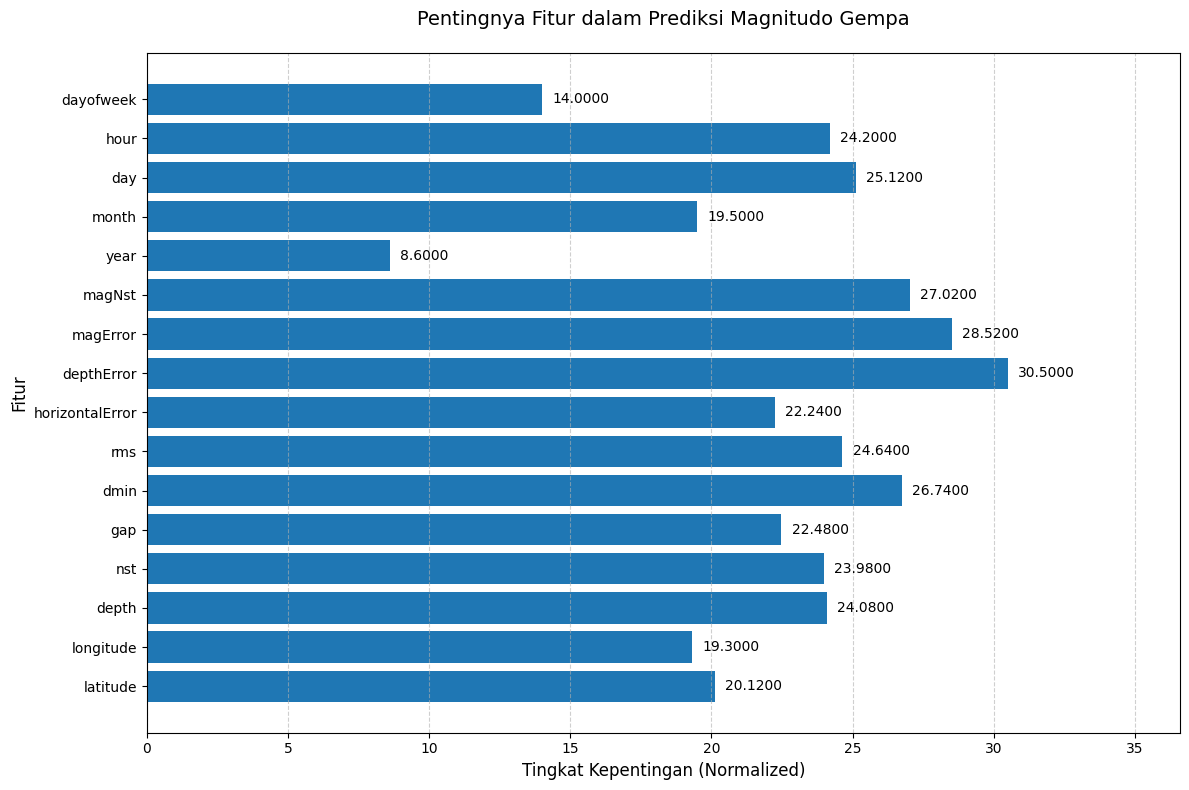

2025-04-07 11:06:21,416 - INFO - Feature importance disimpan ke 'feature_importance.csv'
2025-04-07 11:06:21,416 - INFO - 
9. Menampilkan distribusi maglevel...


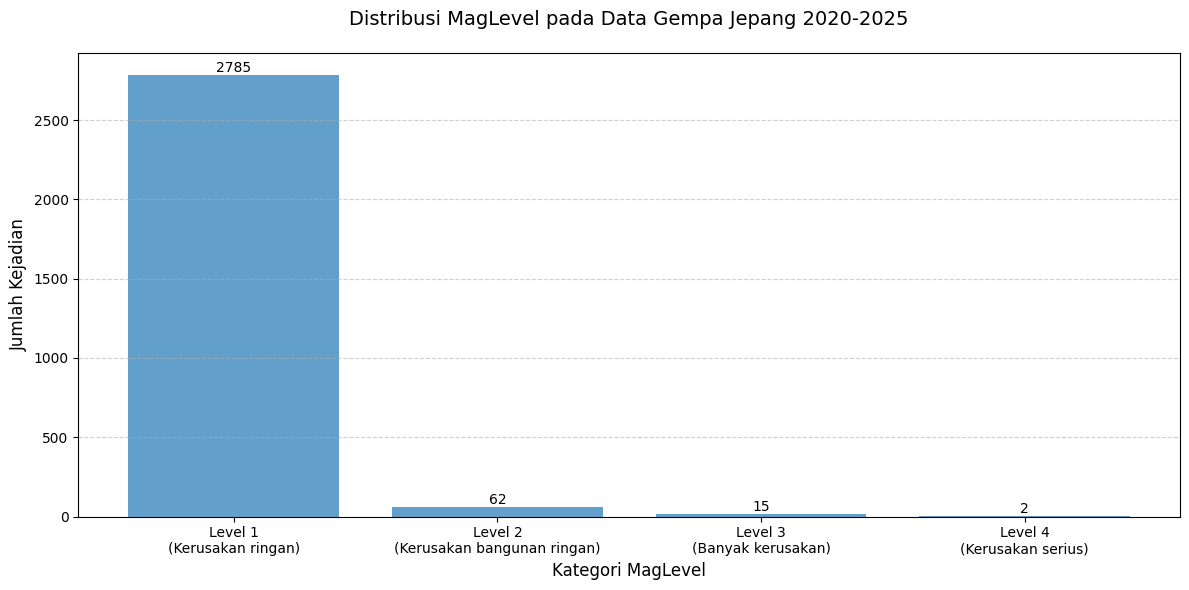

2025-04-07 11:06:21,855 - INFO - 
10. Menampilkan plot magnitudo vs kategori...


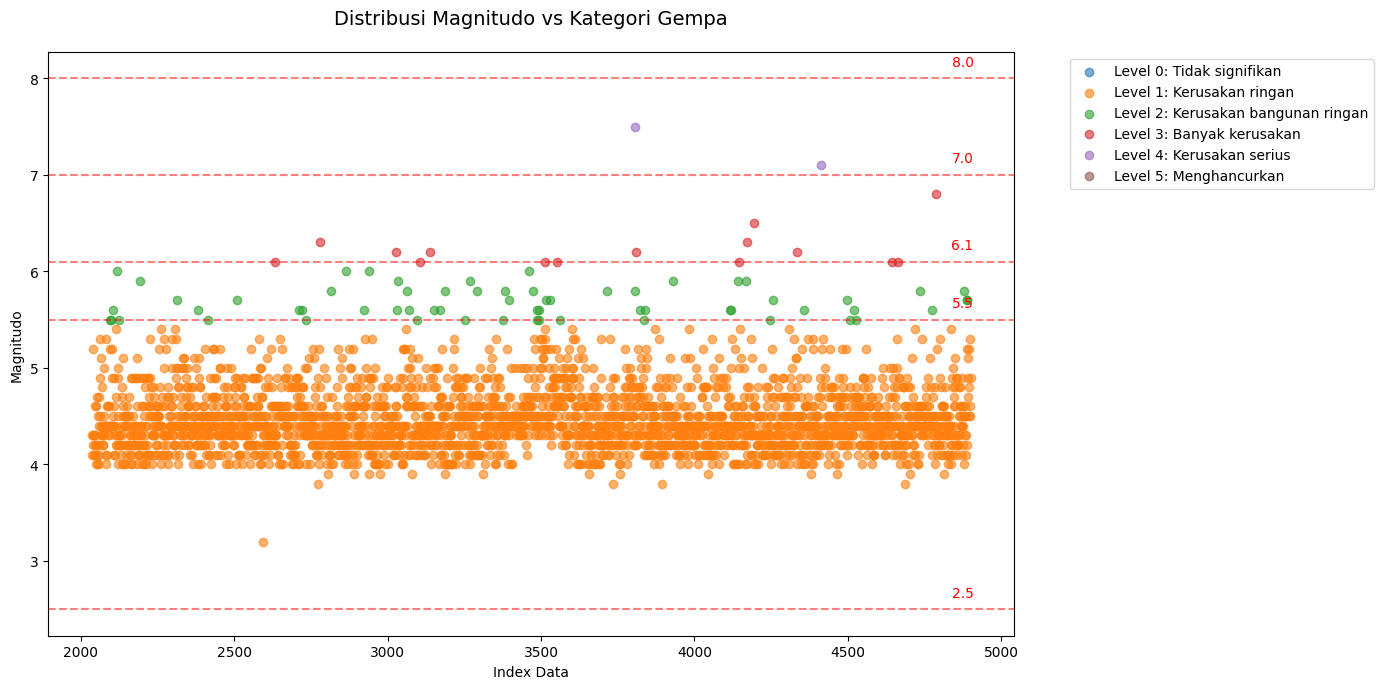

2025-04-07 11:06:22,721 - INFO - 
11. Menampilkan plot prediksi vs nilai aktual...
2025-04-07 11:06:22,831 - INFO - 
12. Menampilkan plot residual...
2025-04-07 11:06:22,926 - INFO - 
Proses selesai!


In [16]:
if __name__ == '__main__':
    # 1. Load Data
    logger.info("Memulai proses...")
    logger.info("1. Memuat dataset...")
    df = pd.read_csv('query.csv')
    
    features = [
        'latitude', 'longitude', 'depth',
								'nst', 'gap', 'dmin', 'rms', 
								'horizontalError', 'depthError', 'magError', 'magNst'
								]
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['dayofweek'] = df['time'].dt.dayofweek
    time_features = ['year', 'month', 'day', 'hour', 'dayofweek']
    features.extend(time_features)
    categorical_features = ['magType', 'type', 'status', 'locationSource', 'magSource']
    for feature in categorical_features:
        if feature in df.columns:
            # Hapus kolom asli dari daftar fitur jika ada
            if feature in features:
                features.remove(feature)

            # Lakukan one-hot encoding
            encoded_features = pd.get_dummies(df[feature], prefix=feature)
            df = pd.concat([df, encoded_features], axis=1)

            # Tambahkan kolom hasil encoding ke daftar fitur
            features.extend(encoded_features.columns.tolist())

    # Pastikan semua fitur adalah numerik
    numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
    features = numeric_features

    target = 'mag'
    
    # Menghapus baris dengan nilai null pada fitur yang digunakan
    df = df.dropna(subset=features + [target])
    
    logger.info(f"Dataset dimuat. Jumlah sampel: {len(df)}, Fitur: {len(features)}")
    logger.info(f"Fitur yang digunakan: {features}")
    
    # 2. Preprocessing
    logger.info("2. Melakukan preprocessing data...")
    
    # Periksa distribusi data
    logger.info(f"Distribusi magnitudo: min={df[target].min()}, max={df[target].max()}, mean={df[target].mean()}, median={df[target].median()}")
    
    # Deteksi dan tangani outlier
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
    logger.info(f"Jumlah outlier terdeteksi: {len(outliers)}")
    
    # Ekstrak fitur dan target
    X = df[features].values.tolist()
    y = df[target].values.tolist()
    
    # Normalisasi data
    X_normalized = normalize_data(X)
    
    # 3. Exploratory Data Analysis
    logger.info("3. Melakukan exploratory data analysis...")
    # Feature correlation analysis
    numeric_features = df[features].select_dtypes(include=['float64', 'int64']).columns.tolist()
    if len(numeric_features) >= 2:  # Need at least 2 features for correlation
        correlation_matrix = df[numeric_features + [target]].corr()
        logger.info("Korelasi fitur dengan magnitudo:")
        for feature in numeric_features:
            corr_value = correlation_matrix.loc[feature, target]
            logger.info(f"  {feature}: {corr_value:.4f}")
    
    # 4. Train-Test Split
    logger.info("4. Membagi data menjadi training dan test set...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y, test_size=0.2, random_state=42, stratify=create_mag_levels(y)
    )
    
    # 5. Hyperparameter Grid
    param_grid = {
        'n_trees': [50, 100, 150],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 15],
        'feature_subset_ratio': [0.5, 0.7, 0.9]
    }
    
    # 6. Grid Search dengan Early Stopping
    logger.info("5. Memulai grid search untuk mencari parameter terbaik...")
    best_score = float('inf')
    best_params = {}
    early_stop_counter = 0
    max_no_improvement = 25  
    
    total_combinations = (
        len(param_grid['n_trees']) * 
        len(param_grid['max_depth']) * 
        len(param_grid['min_samples_split']) * 
        len(param_grid['feature_subset_ratio'])
    )
    current_combination = 0
    
				
    
    for n_trees in param_grid['n_trees']:
        for depth in param_grid['max_depth']:
            for min_split in param_grid['min_samples_split']:
                for ratio in param_grid['feature_subset_ratio']:
                    current_combination += 1
                    logger.info(f"\nEvaluasi kombinasi {current_combination}/{total_combinations}: "
                                f"n_trees={n_trees}, depth={depth}, min_split={min_split}, ratio={ratio}")
                    cv_scores = []  # <-- TAMBAHKAN INI
                    kf = manual_kfold_split(n_samples=len(X_train), n_splits=5, shuffle=True, random_state=42)
                    fold = 1
                    for train_idx, val_idx in kf:
                            logger.info(f"  Fold {fold}/5:")
                            fold += 1
                            
                            X_train_cv = [X_train[i] for i in train_idx]
                            y_train_cv = [y_train[i] for i in train_idx]
                            X_val = [X_train[i] for i in val_idx]
                            y_val = [y_train[i] for i in val_idx]
                            
                            model = EarthquakePredictor(n_trees, depth, min_split, ratio)
                            model.fit(X_train_cv, y_train_cv)
                            
                            preds, _ = model.predict(X_val)
                            mse = np.mean((np.array(y_val) - preds)**2)
                            cv_scores.append(mse)  # <-- SEKARANG TIDAK ERROR
                    avg_score = np.mean(cv_scores)
                    std_score = np.std(cv_scores)
                    
                    # Update best params
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {
                            'n_trees': n_trees,
                            'max_depth': depth,
                            'min_samples_split': min_split,
                            'feature_subset_ratio': ratio
                        }
                        logger.info(f"    ! Kombinasi baru terbaik ditemukan. MSE: {avg_score:.4f} ± {std_score:.4f}")
                        early_stop_counter = 0  # Reset counter
                    else:
                        logger.info(f"    Kombinasi saat ini. MSE: {avg_score:.4f} ± {std_score:.4f} (Terbaik: {best_score:.4f})")
                        early_stop_counter += 1
                    
                    # Early stopping
                    if early_stop_counter >= max_no_improvement:
                        logger.info(f"Berhenti lebih awal setelah {max_no_improvement} kombinasi tanpa perbaikan")
                        break
                
                if early_stop_counter >= max_no_improvement:
                    break
            
            if early_stop_counter >= max_no_improvement:
                break
        
        if early_stop_counter >= max_no_improvement:
            break
    
    # 7. Train Final Model dengan Best Params
    logger.info("\n6. Melatih model final dengan parameter terbaik...")
    logger.info(f"Parameter terbaik: {best_params}")
    
    final_model = EarthquakePredictor(**best_params, num_threads=min(6, os.cpu_count() - 1))
    final_model.fit(X_train, y_train)
    
    model_filename = f'earthquake_predictor_model_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl'
    final_model.save_model(model_filename)
    logger.info(f"Model disimpan ke disk sebagai '{model_filename}'")
    
    # 8. Evaluasi di Test Set
    logger.info("\n7. Mengevaluasi model pada test set...")
    mag_pred, class_pred = final_model.predict(X_test)
    
    # Evaluasi regresi
    final_mse = np.mean((np.array(y_test) - mag_pred)**2)
    final_rmse = np.sqrt(final_mse)
    final_mae = np.mean(np.abs(np.array(y_test) - mag_pred))
    final_r2 = 1 - (np.sum((np.array(y_test) - mag_pred)**2) / np.sum((np.array(y_test) - np.mean(y_test))**2))
    
    logger.info(f"Test MSE (Regresi): {final_mse:.4f}")
    logger.info(f"Test RMSE (Regresi): {final_rmse:.4f}")
    logger.info(f"Test MAE (Regresi): {final_mae:.4f}")
    logger.info(f"Test R² (Regresi): {final_r2:.4f}")
    
    # Evaluasi klasifikasi
    y_test_class = create_mag_levels(y_test)
    accuracy = np.mean(class_pred == y_test_class)
    logger.info(f"Test Accuracy (Klasifikasi): {accuracy:.4f}")
    
    # Precision, Recall, F1-Score untuk tiap kelas
    logger.info("\nClassification Report:")
    
    
    # Tampilkan confusion matrix
    logger.info("\nConfusion Matrix:")
    confusion = np.zeros((6, 6))
    for true, pred in zip(y_test_class, class_pred):
        confusion[true, pred] += 1
    
    confusion_df = pd.DataFrame(confusion, 
                              index=final_model.class_names, 
                              columns=final_model.class_names)
    logger.info(f"\n{confusion_df}")
    
    # Tampilkan contoh prediksi
    sample_indices = np.random.choice(len(X_test), min(10, len(X_test)), replace=False)
    sample_results = final_model.predict_with_details([X_test[i] for i in sample_indices])
    sample_actual = [y_test[i] for i in sample_indices]
    
    logger.info("\nContoh Hasil Prediksi:")
    for i, (res, actual) in enumerate(zip(sample_results, sample_actual)):
        logger.info(f"\nContoh {i+1}:")
        logger.info(f"Magnitudo Prediksi: {res['magnitude']:.2f}, Actual: {actual:.2f}, Error: {abs(res['magnitude'] - actual):.2f}")
        logger.info(f"Kategori: {res['category_name']} (Level {res['category']})")
        logger.info(f"Deskripsi: {res['description']}")
    
    # 9. Visualisasi Feature Importance
    logger.info("\n8. Menghitung dan memvisualisasikan feature importance...")
    feature_importances = final_model.regressor.calculate_feature_importance()
    
    # Pastikan jumlah fitur sesuai dan tambahkan nama fitur
    if len(feature_importances) == len(features):
        visualize_feature_importance(feature_importances, features)
        
        # Simpan feature importance ke file
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)
        
        importance_df.to_csv('feature_importance.csv', index=False)
        logger.info("Feature importance disimpan ke 'feature_importance.csv'")
    else:
        logger.error(f"Jumlah fitur importance ({len(feature_importances)}) tidak sesuai dengan jumlah fitur ({len(features)})")
    
    # 10. Visualisasi MagLevel Distribution
    logger.info("\n9. Menampilkan distribusi maglevel...")
    plot_maglevel_distribution(df[target].values, title='Distribusi MagLevel pada Data Gempa Jepang 2020-2025')
    
    # 11. Visualisasi Magnitudo vs Kategori
    logger.info("\n10. Menampilkan plot magnitudo vs kategori...")
    plot_magnitude_vs_category(df, mag_column=target)
    
    # 12. Visualisasi Prediksi vs Aktual
    logger.info("\n11. Menampilkan plot prediksi vs nilai aktual...")
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, mag_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Magnitudo Aktual')
    plt.ylabel('Magnitudo Prediksi')
    plt.title('Perbandingan Prediksi vs Nilai Aktual')
    plt.savefig('prediction_vs_actual.png')
    plt.close()
    
    # 13. Visualisasi Residual
    logger.info("\n12. Menampilkan plot residual...")
    residuals = np.array(y_test) - mag_pred
    plt.figure(figsize=(10, 8))
    plt.scatter(mag_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Magnitudo Prediksi')
    plt.ylabel('Residual (Aktual - Prediksi)')
    plt.title('Plot Residual')
    plt.savefig('residual_plot.png')
    plt.close()
    
    
    
    logger.info("\nProses selesai!")

Program main tersebut merupakan bagian utama dari sistem prediksi magnitudo gempa bumi berbasis machine learning yang dirancang untuk melakukan pemrosesan data, pelatihan model, evaluasi, serta visualisasi hasil. Program ini dimulai dengan memuat dataset gempa yang berisi berbagai informasi seperti lokasi, waktu, kedalaman, dan jenis gempa. Setelah data dimuat, dilakukan ekstraksi fitur waktu dan one-hot encoding terhadap fitur kategorikal untuk menghasilkan dataset yang siap diproses oleh model. Selanjutnya, data dinormalisasi dan dilakukan analisis eksploratif seperti distribusi magnitudo dan korelasi antar fitur. Program ini juga menerapkan grid search dengan early stopping untuk mencari kombinasi hiperparameter terbaik dalam pelatihan model EarthquakePredictor. Setelah mendapatkan parameter optimal, model dilatih menggunakan data pelatihan dan diuji pada data pengujian untuk mengukur performa regresi dan klasifikasi, termasuk metrik seperti MSE, RMSE, MAE, R², dan accuracy. Program juga menghasilkan visualisasi penting seperti feature importance, distribusi kategori magnitudo, prediksi vs aktual, dan plot residual untuk membantu pemahaman performa model. Hasil model akhir disimpan dalam bentuk file, serta beberapa log dan grafik disimpan untuk dokumentasi dan analisis lebih lanjut. Program ini menunjukkan penerapan pipeline machine learning yang komprehensif dan terstruktur, dari tahap awal pemrosesan data hingga evaluasi dan penyimpanan hasil.

Program ini adalah pipeline lengkap untuk
1. Memprediksi magnitudo gempa bumi dari data historis
2. Mengklasifikasikan level magnitudo
3. Memilih parameter terbaik secara otomatis
4. Mengevaluasi dan memvisualisasikan hasil prediksi
5. Menyimpan model dan hasil penting untuk digunakan kembali

In [18]:
try:
    # 1. Load model
    loaded_model = EarthquakePredictor.load_model('earthquake_predictor_model_20250405_1931.pkl')
    logger.info(f"Model berhasil dimuat. Fitur yang diperlukan: {loaded_model.features}")
    logger.info(f"Total fitur yang dibutuhkan: {len(loaded_model.features)}")
    
    # 2. Siapkan data input sesuai urutan fitur training
    # Contoh data dengan nilai default (sesuaikan dengan data aktual Anda)
    input_data = {
        'latitude': 36.12,
        'longitude': 138.05,
        'depth': 15,
        'nst': 90,
        'gap': 1.32,
        'dmin': 0.65,
        'rms': 7.0,
        'horizontalError': 3.5,
        'depthError': 0.005,
        'magError': 8.7,
        'magNst': 100,
        'year': 2023,
        'month': 4,
        'day': 4,
        'hour': 12,
        'dayofweek': 2,  # Contoh: 2 untuk Selasa
        # Untuk fitur one-hot encoded, beri nilai 0 atau 1
    }
    
    # 3. Konversi ke format array sesuai urutan fitur
    new_data = [[input_data[feature] for feature in loaded_model.features]]
    logger.info(f"Data input yang dibuat: {new_data}")
    
    # 4. Normalisasi
    normalized_new_data = normalize_data(new_data)
    
    # 5. Prediksi
    results = loaded_model.predict_with_details(normalized_new_data)
    
    # 6. Tampilkan hasil
    for result in results:
        print("\n=== Hasil Prediksi ===")
        print(f"Magnitudo: {result['magnitude']:.1f}")
        print(f"Kategori: {result['category_name']} (Level {result['category']})")
        print(f"Deskripsi: {result['description']}")

except Exception as e:
    logger.error(f"Error: {str(e)}", exc_info=True)
    logger.error("Pastikan:")
    logger.error("1) Jumlah fitur sama dengan saat training")
    logger.error("2) Urutan fitur sesuai dengan yang digunakan saat training")
    logger.error("3) Nilai fitur kategorikal sudah di-encode dengan benar")

2025-04-07 14:20:50,272 - INFO - Model berhasil dimuat. Fitur yang diperlukan: ['latitude', 'longitude', 'depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst', 'year', 'month', 'day', 'hour', 'dayofweek']
2025-04-07 14:20:50,285 - INFO - Total fitur yang dibutuhkan: 16
2025-04-07 14:20:50,286 - INFO - Data input yang dibuat: [[36.12, 138.05, 15, 90, 1.32, 0.65, 7.0, 3.5, 0.005, 8.7, 100, 2023, 4, 4, 12, 2]]
2025-04-07 14:20:50,289 - INFO - Memulai prediksi 1 sampel...
2025-04-07 14:20:50,290 - INFO - Diproses 10/50 pohon | Waktu: 0.00s
2025-04-07 14:20:50,291 - INFO - Diproses 20/50 pohon | Waktu: 0.00s
2025-04-07 14:20:50,292 - INFO - Diproses 30/50 pohon | Waktu: 0.00s
2025-04-07 14:20:50,293 - INFO - Diproses 40/50 pohon | Waktu: 0.00s
2025-04-07 14:20:50,293 - INFO - Diproses 50/50 pohon | Waktu: 0.00s
2025-04-07 14:20:50,293 - INFO - Prediksi selesai



=== Hasil Prediksi ===
Magnitudo: 4.4
Kategori: Kerusakan ringan (Level 1)
Deskripsi: Kerusakan ringan (Magnitudo 2.5-5.4) - Menyebabkan kerusakan ringan
